# Exercises - Feature Engineering

1. Load the tips dataset.

In [86]:
from pydataset import data

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [87]:
df = data('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


a. Create a column named price_per_person. This should be the total bill divided by the party size.

In [88]:
df['price_per_person'] = round(df['total_bill'] / df['size'], 2)
df.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.49
2,10.34,1.66,Male,No,Sun,Dinner,3,3.45
3,21.01,3.50,Male,No,Sun,Dinner,3,7.00
4,23.68,3.31,Male,No,Sun,Dinner,2,11.84
5,24.59,3.61,Female,No,Sun,Dinner,4,6.15


b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

- I believe the amount of the total bill, size of the party, and price per person are going to be the most important for predicting the tip amount.

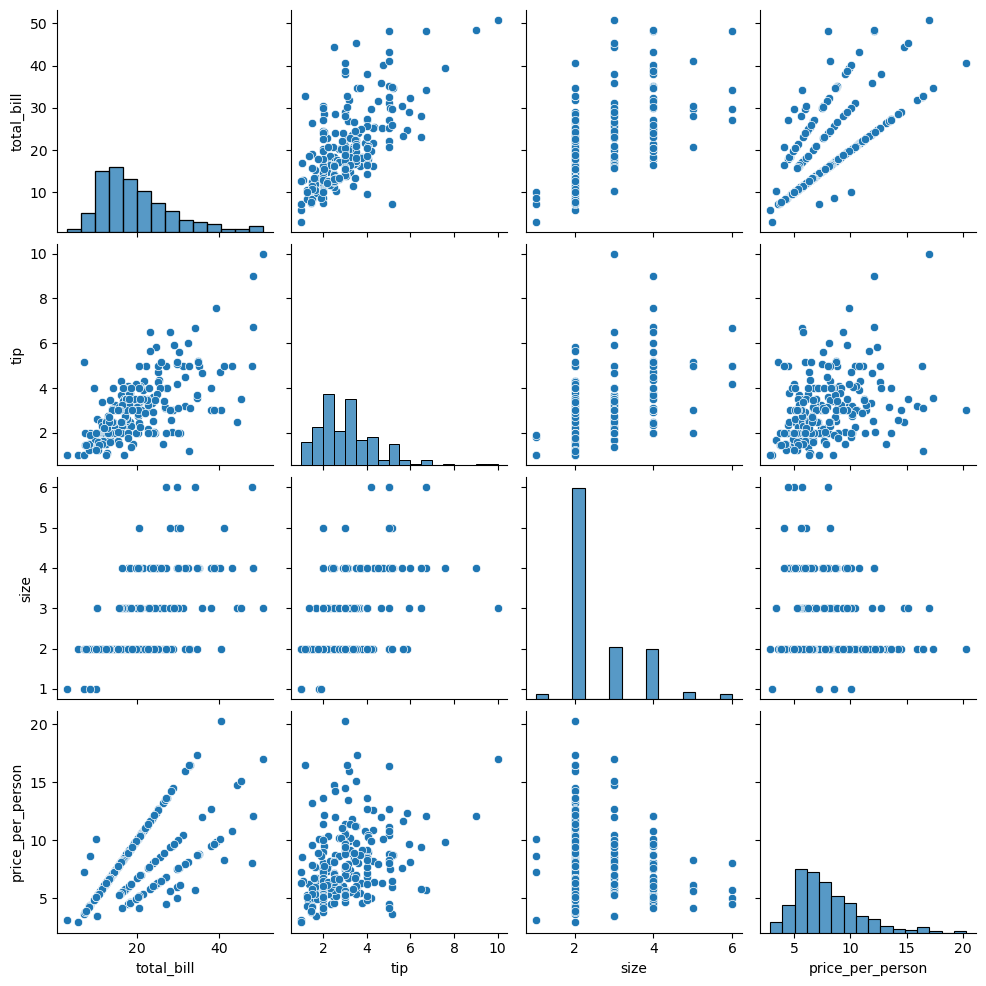

In [89]:
sns.pairplot(data=df)
plt.show()

c. Use select k best to select the top 2 features for predicting tip amount. What are they?

In [90]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

train.shape, validate.shape, test.shape

((136, 8), (59, 8), (49, 8))

In [91]:
mms = MinMaxScaler()
train[['total_bill', 'size', 'price_per_person']] = mms.fit_transform(train[['total_bill', 'size', 'price_per_person']])
train.head()

,total_bill,tip,sex,smoker,day,time,size,price_per_person
19,0.307114,3.50,Female,No,Sun,Dinner,0.4,0.150581
173,0.092355,5.15,Male,Yes,Sun,Dinner,0.2,0.031977
119,0.206805,1.80,Female,No,Thur,Lunch,0.2,0.183140
29,0.411622,4.30,Male,No,Sat,Dinner,0.2,0.452326
238,0.657534,1.17,Male,Yes,Sat,Dinner,0.2,0.776163


In [92]:
X_train_scaled = train[['total_bill', 'size', 'price_per_person']]
y_train = train['tip']

In [93]:
f_selector = SelectKBest(f_regression, k=2)

In [94]:
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7feb6435c310>)

In [95]:
f_select_mask = f_selector.get_support()

In [96]:
X_train_scaled.columns[f_select_mask]

Index(['total_bill', 'size'], dtype='object')

d. Use recursive feature elimination to select the top 2 features for tip amount. What are they?

In [97]:
X_train = train.drop(columns=['tip'])

In [98]:
X_train = pd.get_dummies(X_train, columns=['sex', 'smoker', 'day', 'time'])
X_train.head()

,total_bill,size,price_per_person,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
19,0.307114,0.4,0.150581,1,0,1,0,0,0,1,0,1,0
173,0.092355,0.2,0.031977,0,1,0,1,0,0,1,0,1,0
119,0.206805,0.2,0.183140,1,0,1,0,0,0,0,1,0,1
29,0.411622,0.2,0.452326,0,1,1,0,0,1,0,0,1,0
238,0.657534,0.2,0.776163,0,1,0,1,0,1,0,0,1,0


In [99]:
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select=2)

In [100]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [101]:
ranks = rfe.ranking_
columns = X_train.columns.tolist()

In [102]:
feature_ranks = pd.DataFrame({'ranking': ranks, 'feature': columns})

In [103]:
feature_ranks.sort_values('ranking')

,ranking,feature
0,1,total_bill
2,1,price_per_person
1,2,size
3,3,sex_Female
10,4,day_Thur
8,5,day_Sat
4,6,sex_Male
7,7,day_Fri
5,8,smoker_No
9,9,day_Sun


e. Why do you think select k best and recursive feature elimination might give different answers for the top features? Does this change as you change the number of features you are selecting?

- There is only one different feature between k best and feature elimination. k best has size and feature elimination has the new column price per person. I think the new column is selected because it has two features included as one.

- As the number of feature increases, the number of features selected changes in the ranking

2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [104]:
def select_kbest(X, y, k):
    f_selector = SelectKBest(f_regression, k=k)
    f_selector.fit(X, y)
    f_select_mask = f_selector.get_support()
    return X.columns[f_select_mask]

select_kbest(X_train_scaled, y_train, 2)

Index(['total_bill', 'size'], dtype='object')

3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [105]:
def rfe(X, y, n):
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=n)
    rfe.fit(X, y)
    ranks = rfe.ranking_
    columns = X.columns.tolist()
    feature_ranks = pd.DataFrame({'ranking': ranks, 'feature': columns})
    return feature_ranks.sort_values('ranking')

rfe(X_train, y_train, 4)

,ranking,feature
0,1,total_bill
1,1,size
2,1,price_per_person
3,1,sex_Female
10,2,day_Thur
8,3,day_Sat
4,4,sex_Male
7,5,day_Fri
5,6,smoker_No
9,7,day_Sun


4. Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [106]:
swiss_df = data('swiss')
swiss_df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [107]:
train_validate, test = train_test_split(swiss_df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

train.shape, validate.shape, test.shape

((25, 6), (12, 6), (10, 6))

In [108]:
mms = MinMaxScaler()
train[['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']] = mms.fit_transform(train[['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']])
train.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Rolle,60.5,0.647561,0.40625,0.290323,0.054508,0.122449
Lavaux,65.1,0.796341,0.50000,0.258065,0.004508,0.500000
Nyone,56.6,0.526829,0.59375,0.354839,0.130533,0.163265
Conthey,75.5,0.953659,0.00000,0.032258,0.997029,0.000000
Yverdon,65.4,0.509756,0.37500,0.225806,0.037910,0.755102


In [109]:
X_train_scaled = train[['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']]
y_train = train['Fertility']

In [110]:
select_kbest(X_train_scaled, y_train, 3)

Index(['Examination', 'Catholic', 'Infant.Mortality'], dtype='object')

In [111]:
X_train = train.drop(columns=['Fertility'])

In [112]:
rfe(X_train, y_train, 3)

,ranking,feature
0,1,Agriculture
1,1,Examination
4,1,Infant.Mortality
3,2,Catholic
2,3,Education
